<a href="https://colab.research.google.com/github/amadousysada/image-segmentation/blob/main/p8_01_exploration_and_features_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Import des librairies

In [77]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt

print("Versions:")
print(f"{' '*2}- Pandas       =>: {pd.__version__}")
print(f"{' '*2}- Numpy        =>: {np.__version__}")
print(f"{' '*2}- tensorflow   =>: {tf.__version__}")
print(f"{' '*2}- keras        =>: {tf.keras.__version__}")
print(f"{' '*2}- matplotlib   =>: {plt.matplotlib.__version__}")

Versions:
  - Pandas       =>: 2.2.2
  - Numpy        =>: 2.0.2
  - tensorflow   =>: 2.18.0
  - keras        =>: 3.8.0
  - matplotlib   =>: 3.10.0


In [76]:
base_path = "/content/drive/MyDrive/data/"
image_dir = os.path.join(base_path, "leftImg8bit")
mask_dir = os.path.join(base_path, "gtFine")

In [90]:
def remap_mask(mask):
    out = np.zeros(mask.shape[:2], dtype=np.uint8)
    for orig_id, new_id in CLASS_MAP.items():
        out[mask == orig_id] = new_id
    return out

def augment_data(image, mask):
    # flip horizontal aléatoire
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask  = tf.image.flip_left_right(mask[..., tf.newaxis])[..., 0]
    # légère variation de contraste
    image = tf.image.random_contrast(image, 0.8, 1.2)
    # légère variation de luminosité
    image = tf.image.random_brightness(image, 0.1)
    return image, mask


def make_dataset(image_size=(256, 256), data_type="train", batch_size=32, validation_split=0.3, augment=False):
  images_path = []
  masks_path = []

  for city in os.listdir(f"{image_dir}/{data_type}"):
    image_path = os.path.join(image_dir, data_type, city)
    mask_path = os.path.join(mask_dir, data_type, city)
    for image in os.listdir(image_path):
      if image.endswith("_leftImg8bit.png"):
        base = image.replace("_leftImg8bit.png", "")
        mask = base + "_gtFine_labelIds.png"
        if os.path.exists(os.path.join(mask_path, mask)):
          images_path.append(os.path.join(image_path, image))
          masks_path.append(os.path.join(mask_path, mask))

  ds = tf.data.Dataset.from_tensor_slices((images_path, masks_path))

  def _load(i, m):
    # Read and decode the image and mask using TensorFlow operations
    img = tf.image.decode_png(tf.io.read_file(i), channels=3)
    mask = tf.image.decode_png(tf.io.read_file(m), channels=1)

    # Resize the images
    img = tf.image.resize(img, image_size, method=tf.image.ResizeMethod.BILINEAR)
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.image.resize(mask, image_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, tf.int32)

    return img, mask

  ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)

  if augment:
    ds = ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

  ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return ds

In [91]:
train_ds = make_dataset(data_type="train", batch_size=32, augment=False)

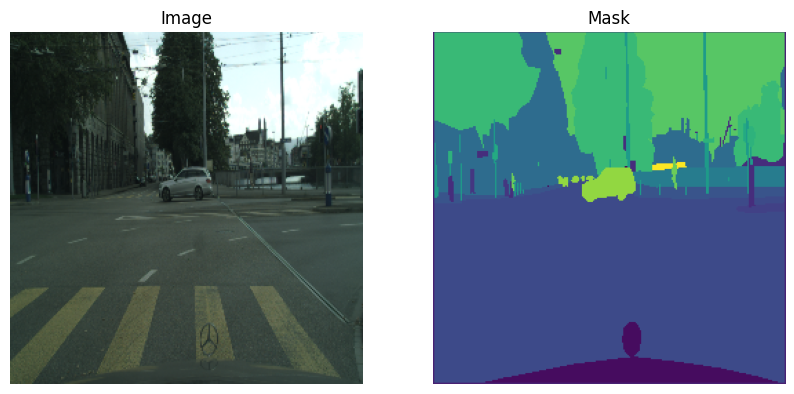

In [95]:
for imgs, masks in train_ds.take(1):
  img = imgs[1].numpy()
  mask = masks[1].numpy()

  plt.figure(figsize=(10, 10))
  ax= plt.subplot(1, 2, 1)
  ax.imshow(img)
  plt.title("Image")
  plt.axis("off")

  ax = plt.subplot(1, 2, 2)
  ax.imshow(mask)
  plt.title("Mask")
  plt.axis("off")

  plt.show()